** <h1 align='centre'> Plant Disease Detection using CNN </h1> **


# Import the various packages required

In [1]:
import numpy as np
import pickle
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
EPOCHS, INIT_LR, BS = 25 , 1e-3 , 64 
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillage/'
width,height,depth = 256,256,3

# Function to convert images to array using OpenCV

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)  #read img using imread function of cv2
        
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :".format(e))
        return None

# Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("Loading images")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print("Processing______".format(plant_disease_folder))
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed")  
except Exception as e:
    print("Error ".format(e))

Loading images
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Processing______
Image loading completed


# Get Size of Processed Image

In [5]:
image_size = len(image_list)
print(image_size)

2952


# Transform Image Labels using LabelBinarizer from sklearn -  

### convert each image label to binary levels.

In [6]:
label_binarizer = LabelBinarizer() # initialize Label Binarizer.

In [7]:
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

# Print the classes

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

# Splitting Dataset into train and test set


### 80% Train and 20% Test set.

In [10]:
print("spliting data to train and test sets. ")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

spliting data to train and test sets. 


# Data Augmentation

### to perform random rotations, shifts, flips, crops, and sheers on our image dataset so that we have good accuracy despite using smaller dataset due to memory constraints. 

In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# Define CNN

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

# Model Summary

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [14]:
from keras.utils.vis_utils import plot_model


# Model architecture saved to files.

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("training network...")

training network...


In [17]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
36/36 [==============================] - 38s 1s/step - loss: 0.2041 - acc: 0.9369 - val_loss: 0.2140 - val_acc: 0.9433
Epoch 2/25
36/36 [==============================] - 33s 919ms/step - loss: 0.1456 - acc: 0.9498 - val_loss: 0.6782 - val_acc: 0.9133
Epoch 3/25
36/36 [==============================] - 32s 888ms/step - loss: 0.1309 - acc: 0.9552 - val_loss: 0.3889 - val_acc: 0.9262
Epoch 4/25
36/36 [==============================] - 33s 917ms/step - loss: 0.1154 - acc: 0.9598 - val_loss: 0.4999 - val_acc: 0.9151
Epoch 5/25
36/36 [==============================] - 32s 897ms/step - loss: 0.1146 - acc: 0.9597 - val_loss: 1.2198 - val_acc: 0.8823
Epoch 6/25
36/36 [==============================] - 32s 894ms/step - loss: 0.1222 - acc: 0.9585 - val_loss: 0.6576 - val_acc: 0.9148
Epoch 7/25
36/36 [==============================] - 33s 908ms/step - loss: 0.0926 - acc: 0.9674 - val_loss: 0.8573 - val_acc: 0.9039
Epoch 8/25
36/36 [==============================] - 32s 889ms/step - los

# Plot the train and val curve

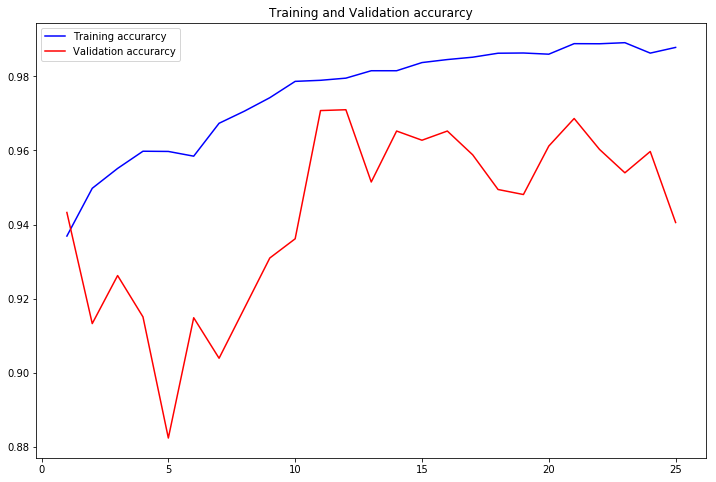

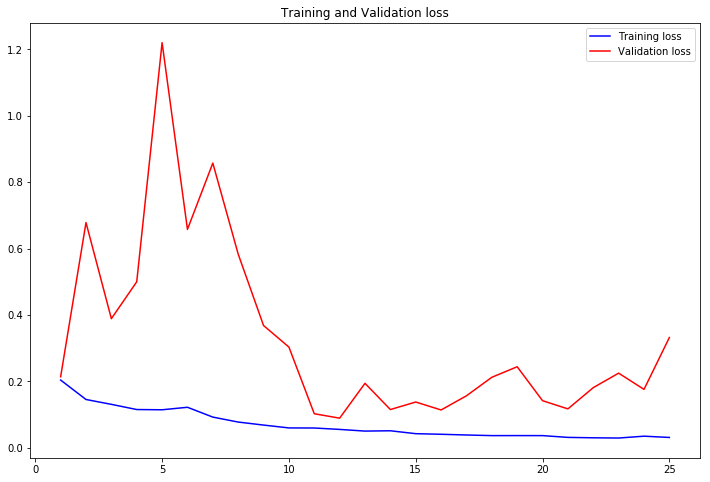

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.figure(figsize = (12,8))
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure(figsize = (12,8))
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Model Accuracy

In [19]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 2s 3ms/step
Test Accuracy: 94.05527384148031


Save model using Pickle

In [20]:
# save the model to disk
print("Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

Saving model...
